In [1]:
# PyTorch imports
import torch
from torch.nn import functional as F

In [2]:
import torch_geometric as ptgeom
import pytorch_lightning as pl
import torch_scatter, torch_sparse
from torchmetrics.functional import accuracy

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

In [3]:
# Finally, Captum
from captum.attr import IntegratedGradients
# from captum.influence import TracInCP, TracInCPFast

In [4]:
mutag = ptgeom.datasets.TUDataset(root='.', name='MUTAG')

Extracting ./MUTAG/MUTAG.zip
Processing...
Done!


In [5]:
print(len(mutag)) # number of graph
print(mutag.num_classes) # if that molecular create mutagenity
print(mutag.num_features) # atom type
print(mutag.num_edge_features) # bond type

188
2
7
4


In [9]:
# Explore dataset
mutag_0 = mutag[0]
print(mutag_0.x, mutag_0.y)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]]) tensor([1])


In [10]:
print(mutag_0.edge_index)

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])


In [11]:
ptgeom.utils.is_undirected(mutag_0.edge_index)

True

In [12]:
# We define a simple function for plotting the graph using the tools from networkx
colors = list(mcolors.TABLEAU_COLORS)

def draw_graph(g: ptgeom.data.Data):
    # Get different color for each atom type
    node_color = [colors[i.item()] for i in g.x.argmax(dim=1)]
    # convert to network x
    g = ptgeom.utils.to_networkx(g, to_undirected=True)
    nx.draw(g, node_color=node_color)

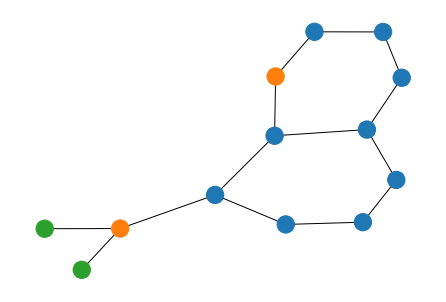

In [14]:
draw_graph(mutag[1])

In [15]:
mutag_adj = ptgeom.datasets.TUDataset(root='.', name='MUTAG', 
                                  transform=ptgeom.transforms.ToSparseTensor())

In [16]:
# First, we split the original dataset into a training and test spart with a stratified split on the class
train_idx, test_idx = train_test_split(range(len(mutag)), stratify=[m.y[0].item() for m in mutag], test_size=0.25)

In [17]:
# Build the two loaders
train_loader = ptgeom.loader.DataLoader(mutag[train_idx], batch_size=32, shuffle=True)
test_loader = ptgeom.loader.DataLoader(mutag[test_idx], batch_size=32)

In [18]:
batch = next(iter(train_loader))
print(batch.x.shape)
print(batch.y.shape)
print(batch.edge_index.shape)

torch.Size([590, 7])
torch.Size([32])
torch.Size([2, 1298])


In [20]:
class MUTAGClassifier(pl.LightningModule):
    
    def __init__(self, ):
        super().__init__()
        self.gc1 = ptgeom.nn.GCNConv(7, 256)
        self.gc2 = ptgeom.nn.GCNConv(256, 256)
        self.linear = torch.nn.Linear(256, 1)
        
    def forward(self, x, edge_index=None, batch=None, edge_weight=None):
      # Note: "edge_weight" is not used for training, but only for the explainability part
      if edge_index == None:
        x, edge_index, batch = x.x, x.edge_index, x.batch
      x = F.relu(self.gc1(x, edge_index, edge_weight))
      x = F.relu(self.gc2(x, edge_index, edge_weight))
      x = ptgeom.nn.global_mean_pool(x, batch)
      x = F.dropout(x)
      x = self.linear(x)
      return x
 
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, _):
        y_hat = self.forward(batch.x, batch.edge_index, batch.batch)
        loss = F.binary_cross_entropy_with_logits(y_hat, batch.y.unsqueeze(1).float())
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy(y_hat, batch.y.unsqueeze(1)), prog_bar=True, batch_size=32)
        return loss

    def validation_step(self, batch, _):
        x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch
        y_hat = self.forward(x, edge_index, batch_idx)
        self.log("val_accuracy", accuracy(y_hat, batch.y.unsqueeze(1)), prog_bar=True, batch_size=32)

In [21]:
# We instantiate the classifier
gnn = MUTAGClassifier()

In [22]:
# Sanity check: we run a single mini-batch and check the output shape
gnn(batch.x, batch.edge_index, batch.batch).shape

torch.Size([32, 1])

In [24]:
# We save checkpoints every 50 epochs (note: not used for now, planning to add TracIn later)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='./checkpoints/',
    filename='gnn-{epoch:02d}',
    every_n_epochs=50,
    save_top_k=-1)

In [26]:
trainer = pl.Trainer(max_epochs=200, callbacks=[checkpoint_callback])

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1826: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,


In [27]:
# This is not a particularly well-designed model, we expect approximately 80% test accuracy
trainer.fit(gnn, train_loader, test_loader)

Missing logger folder: /workspace/GNN_Explainer/lightning_logs

  | Name   | Type    | Params
-----------------------------------
0 | gc1    | GCNConv | 2.0 K 
1 | gc2    | GCNConv | 65.8 K
2 | linear | Linear  | 257   
-----------------------------------
68.1 K    Trainable params
0         Non-trainable params
68.1 K    Total params
0.272     Total estimated model params size (MB)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1942: PossibleUserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_s

In [28]:
# We take a single graph from the test dataset
idx = 0
test_graph = mutag[test_idx[idx]]

In [29]:
print(test_graph.y)

tensor([1])


In [30]:
# remove individual features for each node
explainer = ptgeom.nn.GNNExplainer(gnn, feat_mask_type="individual_feature", epochs=500)

In [31]:
# Run a gradient descent loop to optimize the masks
result = explainer.explain_graph(test_graph.x, test_graph.edge_index)

Explain graph: 100%|█████████████████████████| 500/500 [00:01<00:00, 253.56it/s]


In [32]:
# These are the resulting masks, we mostly care about the edges here
(feature_mask, edge_mask) = result
print(edge_mask.shape)
print(feature_mask.shape)

torch.Size([40])
torch.Size([19, 7])


In [33]:
# get the highest values inside the edge mask 
edges_idx = edge_mask > 0.5


In [34]:
# We build the subgraph corresponding to the explanation
explanation = ptgeom.data.Data(test_graph.x, test_graph.edge_index[:, edges_idx])

In [35]:
# Make undirected and remove the isolated nodes 
explanation = ptgeom.transforms.RemoveIsolatedNodes()(ptgeom.transforms.ToUndirected()(explanation))

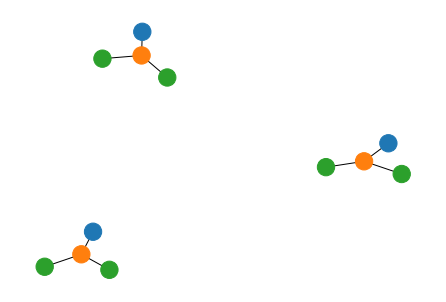

In [36]:
# A good explanation should contain carbon rings, NH2, and NO2 groups, which are known to be mutagenic
draw_graph(explanation)

In [37]:
# We just define a custom function whose input is the edge mask
batch_idx = torch.zeros(test_graph.x.shape[0], dtype=torch.int64) # All nodes belong to the same graph
gnn.eval()
def model_forward(edge_mask):
    out = gnn(test_graph.x, test_graph.edge_index, batch_idx, edge_weight=edge_mask[0])
    return out

In [38]:
# Initialize the edge mask
edge_mask = torch.ones(test_graph.edge_index.shape[1]).unsqueeze(0).requires_grad_(True)

In [39]:
# See the API from here:
# https://captum.ai/docs/extension/integrated_gradients
ig = IntegratedGradients(model_forward)

In [40]:
mask = ig.attribute(edge_mask, internal_batch_size=1)

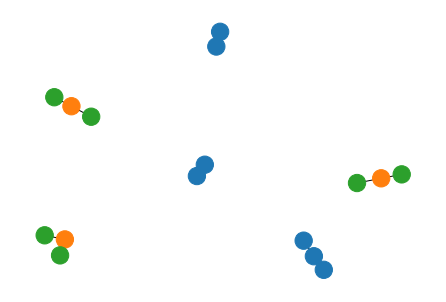

In [41]:
# This is identical to before, using the new mask
explanation = ptgeom.data.Data(test_graph.x, test_graph.edge_index[:, mask[0] > 0.1])
explanation = ptgeom.transforms.RemoveIsolatedNodes()(ptgeom.transforms.ToUndirected()(explanation))
draw_graph(explanation)